## Classify with CNN

## Imports

In [6]:
# Standard library imports
import os
from random import shuffle

# External library imports
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

## Model Training

In [ ]:
# Define paths
DATASET_DIR = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\train'
CATEGORIES = ['met', 'nichtmet']
IMG_SIZE = 150  # Resize images to 150x150

# Function to load and preprocess the images
def load_data():
    data = []
    for category in CATEGORIES:
        path = os.path.join(DATASET_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path)
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([img_array, class_num])
            except Exception as e:
                pass
    return data

# Load and shuffle data
data = load_data()
shuffle(data)

# Split data into features (X) and labels (y)
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

# Normalize the data and reshape it
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array(y)

# One-hot encode the labels
y = to_categorical(y, num_classes=len(CATEGORIES))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CATEGORIES), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate and print per-category accuracies
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
report = classification_report(y_true_classes, y_pred_classes, target_names=CATEGORIES)
print(report)

# Extract accuracy for each category
report_dict = classification_report(y_true_classes, y_pred_classes, target_names=CATEGORIES, output_dict=True)
category_accuracy = [report_dict[category]['precision'] for category in CATEGORIES]

# Plot per-category accuracy
plt.figure(figsize=(10, 5))
plt.bar(CATEGORIES, category_accuracy)
plt.xlabel('Categories')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Category')
plt.show()

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

model.save('metal_classifier_model_with_aug_2.keras')
print("Model saved to metal_classifier_model_with_aug_2.keras")

## Model usage

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


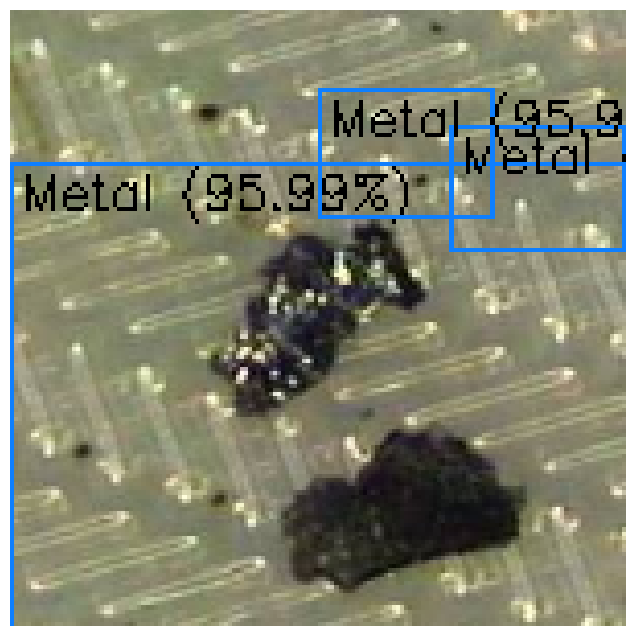

In [9]:
# Load the pre-trained model
model = load_model('metal_classifier_model_with_aug.keras')

# Preprocess image for classification
def preprocess_image(image_path, img_size=150):
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img_array is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")
    img_array = cv2.resize(img_array, (img_size, img_size))
    img_array = img_array.reshape(-1, img_size, img_size, 1)
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Classify the image as 'metal' or 'non-metal'
def classify_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions, axis=1)[0]
    categories = ['metal', 'non-metal']
    return categories[predicted_class]

# Preprocess image for segmentation
def preprocess_image_for_segmentation(image_path, img_size=150):
    img_array = cv2.imread(image_path)
    if img_array is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")
    img_array = cv2.resize(img_array, (img_size, img_size))
    return img_array

# Segment the image and draw bounding boxes
def segment_and_draw_bounding_box(image_path):
    img_array = preprocess_image_for_segmentation(image_path)
    
    _, binary_img = cv2.threshold(cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY_INV)
        
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter out smaller contours
    contours = [contour for contour in contours if cv2.contourArea(contour) > 100]  # Adjust threshold as needed
    
    # Draw bounding boxes on the original image
    img_color = img_array.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        color = (31, 119, 180)  # Default color for non-metal (hex: #1f77b4)
        predicted_category = classify_image(image_path)
        if predicted_category == 'metal':
            color = (255, 127, 14)  # Color for metal (hex: #ff7f0e)
        # Adjust bounding box coordinates based on contour dimensions
        padding = 5  # Add some padding around the object
        x1, y1 = max(0, x - padding), max(0, y - padding)
        x2, y2 = min(img_array.shape[1], x + w + padding), min(img_array.shape[0], y + h + padding)
        cv2.rectangle(img_color, (x1, y1), (x2, y2), color, 1)  # Thin bounding box
        # Write category and confidence inside the bounding box
        preprocessed_image = preprocess_image(image_path)
        predictions = model.predict(preprocessed_image)
        confidence = predictions[0][0 if predicted_category == 'metal' else 1] * 100  # Convert confidence to percentage
        text = f'{predicted_category.capitalize()} ({confidence:.2f}%)'
        font_scale = 0.4
        font = cv2.FONT_HERSHEY_SIMPLEX
        (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, 1)
        text_x = x1 + 2
        text_y = y1 + text_height + 2
        cv2.putText(img_color, text, (text_x, text_y), font, font_scale, (0, 0, 0), 1)  # Black text
    
    # Display the image with bounding boxes and confidence
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Image path
image_path = 'test/met (668).jpg'

# Try segmenting and drawing bounding boxes
try:    
    segment_and_draw_bounding_box(image_path)
except ValueError as e:
    print(e)
